In [1]:
# importing libraries
import os
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from pathlib import Path
from tensorflow.keras.preprocessing import image
from sklearn.decomposition import PCA
from math import ceil
%matplotlib inline

In [2]:
#setting up EVN
environment = "kaggle"# "kaggle" or "local"

In [3]:
%%capture
#%%capture hides the output of this from being printed. Uncomment to check the output

path_for_data = "./csc4851-homework4/" if environment == "local" else "/kaggle/input/csc4851-homework4/"

for dirname, _, filenames in os.walk(path_for_data):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
#Reading all the CSV files
# bird_latin_names = pd.read_csv(path_for_data + 'birds latin names.csv')
birds = pd.read_csv(path_for_data + 'birds_400/birds.csv')
class_dict = pd.read_csv(path_for_data + 'birds_400/class_dict.csv')
submission = pd.read_csv(path_for_data + 'birds_400/submission.csv')

#Pool all the names of files availible
train_images = glob(path_for_data + "birds_400/train/*/*.jpg")
test_images = glob(path_for_data + "birds_400/test/*/*.jpg")
validation_images = glob(path_for_data + "birds_400/valid/*/*.jpg")

print("No of images to train: ", len(train_images))
print("No of images to test: ", len(test_images))
print("No of images to validate: ", len(validation_images))


No of images to train:  58388
No of images to test:  2000
No of images to validate:  2000


In [5]:
#Show the dimensions of the csv data.
print('birds dimensions: ', birds.shape)
print('birds column names: ', birds.columns.values.tolist())
print('birds sample data: ')
print(birds.head())

print('class_dict dimensions: ', class_dict.shape)
print('class_dict column names: ', class_dict.columns.values.tolist())
print('class_dict sample data: ')
print(class_dict.head())

print('submission dimensions: ', submission.shape)
print('submission column names: ', submission.columns.values.tolist())
print('submission sample data: ')
print(submission.head())

birds dimensions:  (62388, 4)
birds column names:  ['class index', 'filepaths', 'labels', 'data set']
birds sample data: 
   class index                      filepaths           labels data set
0            0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER    train
1            0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER    train
2            0  train/ABBOTTS BABBLER/003.jpg  ABBOTTS BABBLER    train
3            0  train/ABBOTTS BABBLER/004.jpg  ABBOTTS BABBLER    train
4            0  train/ABBOTTS BABBLER/005.jpg  ABBOTTS BABBLER    train
class_dict dimensions:  (400, 6)
class_dict column names:  ['class_index', 'class', 'height', 'width', 'scale by', 'Offset']
class_dict sample data: 
   class_index                       class  height  width  scale by  Offset
0            0             ABBOTTS BABBLER     112    112         1       0
1            1               ABBOTTS BOOBY     112    112         1       0
2            2  ABYSSINIAN GROUND HORNBILL     112    112         1 

In [6]:
#EDA for the image files
print('train_images is of type ',type(train_images), ' and length ', len(train_images))
print('train_images list 1st 3 elements: ', train_images[0:3], '\n')

print('test_images is of type ',type(test_images), ' and length ', len(test_images))
print('test_images list 1st 3 elements: ', test_images[0:3])


print('validation_images is of type ',type(validation_images), ' and length ', len(validation_images))
print('validation_images list 1st 3 elements: ', validation_images[0:3])

train_images is of type  <class 'list'>  and length  58388
train_images list 1st 3 elements:  ['/kaggle/input/csc4851-homework4/birds_400/train/WATTLED CURASSOW/029.jpg', '/kaggle/input/csc4851-homework4/birds_400/train/WATTLED CURASSOW/014.jpg', '/kaggle/input/csc4851-homework4/birds_400/train/WATTLED CURASSOW/109.jpg'] 

test_images is of type  <class 'list'>  and length  2000
test_images list 1st 3 elements:  ['/kaggle/input/csc4851-homework4/birds_400/test/WATTLED CURASSOW/5.jpg', '/kaggle/input/csc4851-homework4/birds_400/test/WATTLED CURASSOW/1.jpg', '/kaggle/input/csc4851-homework4/birds_400/test/WATTLED CURASSOW/4.jpg']
validation_images is of type  <class 'list'>  and length  2000
validation_images list 1st 3 elements:  ['/kaggle/input/csc4851-homework4/birds_400/valid/WATTLED CURASSOW/5.jpg', '/kaggle/input/csc4851-homework4/birds_400/valid/WATTLED CURASSOW/1.jpg', '/kaggle/input/csc4851-homework4/birds_400/valid/WATTLED CURASSOW/4.jpg']


/kaggle/input/csc4851-homework4/birds_400/train/WATTLED CURASSOW/029.jpg
(224, 224, 3)


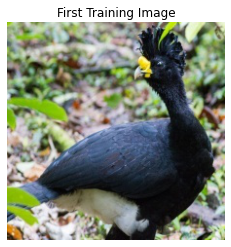

In [7]:
print(train_images[0])
#let's plot that first image:

#get the image path we just printed
image_path = train_images[0]
#use plt.imread() to read in that image file
image_array = plt.imread(image_path) 
print(image_array.shape)

#then plt.imshow() can display it for you
plt.imshow(image_array)
plt.title('First Training Image') 
plt.axis('off') #turns off the gridlines
plt.show()

image 0's dimensions are: (224, 224, 3)


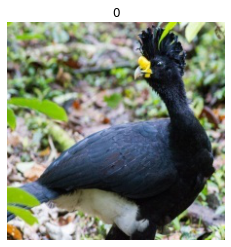

image 1's dimensions are: (224, 224, 3)


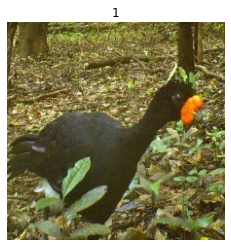

image 2's dimensions are: (224, 224, 3)


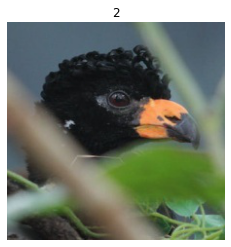

In [8]:
#The for loop goes for 3 loops 
for x in range(3):
    #this loop goes through index of the train_jpg list of filenames: 0,1,2
    image_path = train_images[x]
    #use plt.imread() to read in that image file as an array of numbers between 0-255
    image_array = plt.imread(image_path) 
    #Let's check the image dimensions
    print("image {}'s dimensions are: {}".format(x,image_array.shape))
    #then plt.imshow() can display it for you
    plt.imshow(image_array)
    #title is the index of train_jpg
    plt.title(x) 
    #turn off gridlines
    plt.axis('off')
    #show the image
    plt.show()

In [9]:
def img2np(path, list_of_filename, size = (64, 64)):
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        img_ts = image.img_to_array(current_image)
        img_ts = [img_ts.ravel()]
        try:
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            full_mat = img_ts
    return full_mat

In [10]:
classes = [x[0].split('/')[-1] for x in os.walk(path_for_data+"birds_400/train/")]
classes.pop(0)
# print(classes)

''

In [11]:
training_images = {}
#lets check images of 5 classes, this can be changed by changing the varible value 
no_of_classes = 5
training_images_list = {}
for current_class in classes[:no_of_classes]:
    list_of_names = list(os.walk(path_for_data+"birds_400/train/"+current_class))
    training_images_list[current_class] = list_of_names[0][2]
# print(training_images_list)
for current_class in classes[:no_of_classes]:
    normal_images = img2np(f'{path_for_data}birds_400/train/{current_class}/', training_images_list[current_class])
    training_images[current_class] = normal_images

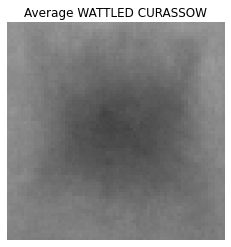

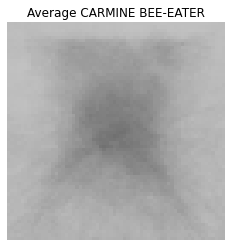

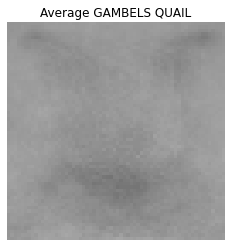

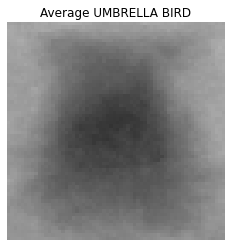

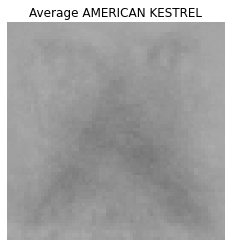

In [12]:
#display the mean for all iages, to see the pixel density
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img
norm_mean = {}
for current_class in classes[:no_of_classes]:
    norm_mean[current_class] = find_mean_img(training_images[current_class], current_class)
    
    
#We can observe the bird size, and alignment in the given dataset. 


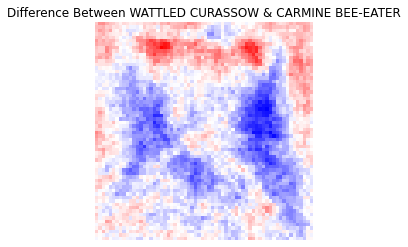

In [13]:
#Let's check difference between each two classes
contrast_mean = norm_mean[classes[0]] - norm_mean[classes[1]]
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between '+classes[0]+' & '+classes[1])
plt.axis('off')
plt.show()

In [14]:
# Extractinf id from an image
image_name = train_images[0]
id_stem = Path(image_name).stem
image_name = image_name.split('/')
print('Image Path: ', image_name)
print('Image id: ', id_stem)
print('Image class: ', image_name[-2])


Image Path:  ['', 'kaggle', 'input', 'csc4851-homework4', 'birds_400', 'train', 'WATTLED CURASSOW', '029.jpg']
Image id:  029
Image class:  WATTLED CURASSOW


In [15]:
#Reading data from csv for a selected image
row_data_from_csv = birds.loc[birds['filepaths'] == "train/"+image_name[-2]+"/"+image_name[-1]]
row_data_from_csv

,class index,filepaths,labels,data set
56320,386,train/WATTLED CURASSOW/029.jpg,WATTLED CURASSOW,train


In [16]:
#count train, test, and validation data for each class
meta_data = {}
for path in train_images:
    path = path.split('/')
    if path[-2] in meta_data:
        meta_data[path[-2]]['train'] += 1
    else:
        meta_data[path[-2]] = { 'train':1, 'test':0, 'validation':0}

for path in test_images:
    path = path.split('/')
    if path[-2] in meta_data:
        meta_data[path[-2]]['test'] += 1
    else:
        meta_data[path[-2]] = { 'test':1, 'train':0, 'validation':0}

for path in test_images:
    path = path.split('/')
    if path[-2] in meta_data:
        meta_data[path[-2]]['validation'] += 1
    else:
        meta_data[path[-2]] = { 'test':0, 'train':0, 'validation':1}

for key in meta_data:
    print("Class name: ", key)
    print("Train images: ", meta_data[key]["train"])
    print("Test images: ", meta_data[key]["test"])
    print("Validation images: ", meta_data[key]["validation"])

Class name:  WATTLED CURASSOW
Train images:  138
Test images:  5
Validation images:  5
Class name:  CARMINE BEE-EATER
Train images:  121
Test images:  5
Validation images:  5
Class name:  GAMBELS QUAIL
Train images:  147
Test images:  5
Validation images:  5
Class name:  UMBRELLA BIRD
Train images:  144
Test images:  5
Validation images:  5
Class name:  AMERICAN KESTREL
Train images:  130
Test images:  5
Validation images:  5
Class name:  AMERICAN GOLDFINCH
Train images:  133
Test images:  5
Validation images:  5
Class name:  DUSKY LORY
Train images:  139
Test images:  5
Validation images:  5
Class name:  BLACK THROATED WARBLER
Train images:  135
Test images:  5
Validation images:  5
Class name:  YELLOW CACIQUE
Train images:  155
Test images:  5
Validation images:  5
Class name:  STRIPPED SWALLOW
Train images:  120
Test images:  5
Validation images:  5
Class name:  VERMILION FLYCATHER
Train images:  155
Test images:  5
Validation images:  5
Class name:  CAPE MAY WARBLER
Train images:  